# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [2]:
name_output = input('enter the name of your output file ').strip()

enter the name of your output file AlexNet


# Import Modules

In [3]:
import tensorflow as tf

In [4]:
# import tensorflow as tf
# from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Reshape, Activation,Flatten,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision,TruePositives,TrueNegatives, FalsePositives,FalseNegatives,Accuracy

In [5]:
import os
import shutil
import glob

import random
import warnings

In [6]:

# warnings.simplefilter(action='ignore',category='FutureWarning')

In [7]:
print('hi')

hi


In [8]:
# print("GPU Name:", tf.config.list_physical_devices('GPU')[0])

# Add GPU

In [9]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
if len(physical_devices) >=1:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPUs Available:  1


# Make your Edits

In [10]:
## change home directory
home = '/content/drive/MyDrive/Projects/CXR'

image_zip = 'chest_xray.zip'

model_name = 'nasnet'

this_model_name =  name_output+'.h5'

# Pull Data and Setup

In [11]:
image_path =  'data'
# os.mkdir(image_path)

# shutil.copy(os.path.join(home,'data',image_zip),image_zip)

In [12]:
# shutil.unpack_archive(image_zip,os.getcwd(),'zip')

## Create Path and arrange

In [13]:
# prompt: ## move test folder from the unzipped folder to the data folder.

# shutil.move('test',image_path)


In [14]:
# # prompt: ## create 3 more folders in the data folder

# os.mkdir(os.path.join(image_path,'train'))
# os.mkdir(os.path.join(image_path,'validate'))
# os.mkdir(os.path.join(image_path,'withhold'))


In [15]:
input_dir = 'train'
train_dir = 'data/train'
val_dir = 'data/validate'
held_dir = 'data/withhold'

### Move data

In [16]:
# # Set the split ratios
# train_ratio = 0.8
# val_ratio = 0.1
# held_ratio = 0.1

# # Set the random seed for reproducibility
# seed = 42
# random.seed(seed)

# # Create the output directories if they don't exist
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)
# os.makedirs(held_dir, exist_ok=True)

# # Loop through each class folder in the input directory
# for class_name in os.listdir(input_dir):
#     class_dir = os.path.join(input_dir, class_name)

#     if os.path.isdir(class_dir):
#         # Create corresponding class directories in the output folders
#         os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
#         os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
#         os.makedirs(os.path.join(held_dir, class_name), exist_ok=True)

#         # Get all file names in the current class directory
#         file_names = os.listdir(class_dir)
#         random.shuffle(file_names)  # Shuffle the file names

#         # Calculate the split indices
#         total_files = len(file_names)
#         train_end = int(train_ratio * total_files)
#         val_end = train_end + int(val_ratio * total_files)

#         # Split the files
#         train_files = file_names[:train_end]
#         val_files = file_names[train_end:val_end]
#         held_files = file_names[val_end:]

#         # Move files to their respective directories
#         for file_name in train_files:
#             shutil.move(os.path.join(class_dir, file_name), os.path.join(train_dir, class_name, file_name))

#         for file_name in val_files:
#             shutil.move(os.path.join(class_dir, file_name), os.path.join(val_dir, class_name, file_name))

#         for file_name in held_files:
#             shutil.move(os.path.join(class_dir, file_name), os.path.join(held_dir, class_name, file_name))

# print("Data split and moved successfully!")


In [17]:
# os.mkdir(os.path.join(image_path,'train'))
# # os.mkdir(os.path.join(image_path,'test'))
# os.mkdir(os.path.join(image_path,'valid'))

In [18]:
# prompt: move test folder from home firectory to data

# shutil.move(os.path.join(home,'data','test'),os.path.join(image_path,'test'))


## Bring data back

In [19]:
# prompt: copy os.path.join(home, 'data','data') to the current directory with python

shutil.copytree(os.path.join(home, 'data','data'), 'data')


'data'

In [20]:
# prompt: check in data the number of items in both folders in train

normal_train_len = len(os.listdir('data/train/NORMAL'))
pneumonia_train_len = len(os.listdir('data/train/PNEUMONIA'))
print('NORMAL:', normal_train_len)
print('PNEUMONIA:', pneumonia_train_len)


NORMAL: 3216
PNEUMONIA: 3100


# Funtions

### Plot Confusion matrix

In [21]:
def plot_confusion_matrix(cm,classes,
                          normalize = False,
                          title='Confusion matrix',
                          cmap = plt.cm.Blues):
  """
  this function prints and plots the confusion matrix
  normalization can be applied by setting normalize=True
  """
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tickmarks=  np.arange(len(classes))
  plt.xticks(tickmarks,classes,rotation=45)
  plt.yticks(tickmarks,classes)
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1) [:,np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('confusion matrix without normalization')

  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(i,j,cm[i,j],
             horizontalalignment='center',
             color = 'white' if cm[i,j] > thresh else 'black'
             )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

# Instantiate the Base Model

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_alexnet(input_shape=(224, 224, 3), num_classes=2):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((3, 3), strides=2),
        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=2),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (5, 5), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=2),
        layers.Flatten(),
        layers.Dense(2048, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Example usage
model = create_alexnet()
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# You can use model.fit() with your training data after this


# Preprocess

In [25]:
def prepare_image(file):
  img = image.load_img(file, target_size = (224,224))
  img_array = image.img_to_array(img)
  # print(img_array.shape)
  img_array_expanded = np.expand_dims(img_array,axis=0)
  # print(img_array_expanded.shape)
  return tf.keras.applications.nasnet.preprocess_input(img_array_expanded)


## Pull data

In [26]:
train_path = os.path.join(image_path,'train')
valid_path = os.path.join(image_path,'validate')
test_path = os.path.join(image_path,'test')

In [27]:
## add augmentations similar to above one  here

train_batches = ImageDataGenerator(
                                   rotation_range = 10, shear_range=0.1, zoom_range = 0.1 )\
              .flow_from_directory(directory= train_path,target_size=(224,224),batch_size=32, class_mode ='categorical')

valid_batches = ImageDataGenerator()\
              .flow_from_directory(directory= valid_path,target_size=(224,224),batch_size=32,  class_mode ='categorical')

test_batches = ImageDataGenerator()\
              .flow_from_directory(directory= test_path,target_size=(224,224),batch_size=32, shuffle = False,  class_mode ='categorical')


Found 6316 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [28]:
labels = train_batches.class_indices
print(labels)

{'NORMAL': 0, 'PNEUMONIA': 1}


## Transfer Learning

In [29]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 384)         │       3,686,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2048)                │      13,109,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4096)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │           8,194 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,616,642 (105.35 MB)

 Trainable params: 27,616,642 (105.35 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 384)         │       3,686,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2048)                │      13,109,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4096)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │           8,194 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,616,642 (105.35 MB)

 Trainable params: 27,616,642 (105.35 MB)

 Non-trainable params: 0 (0.00 B)

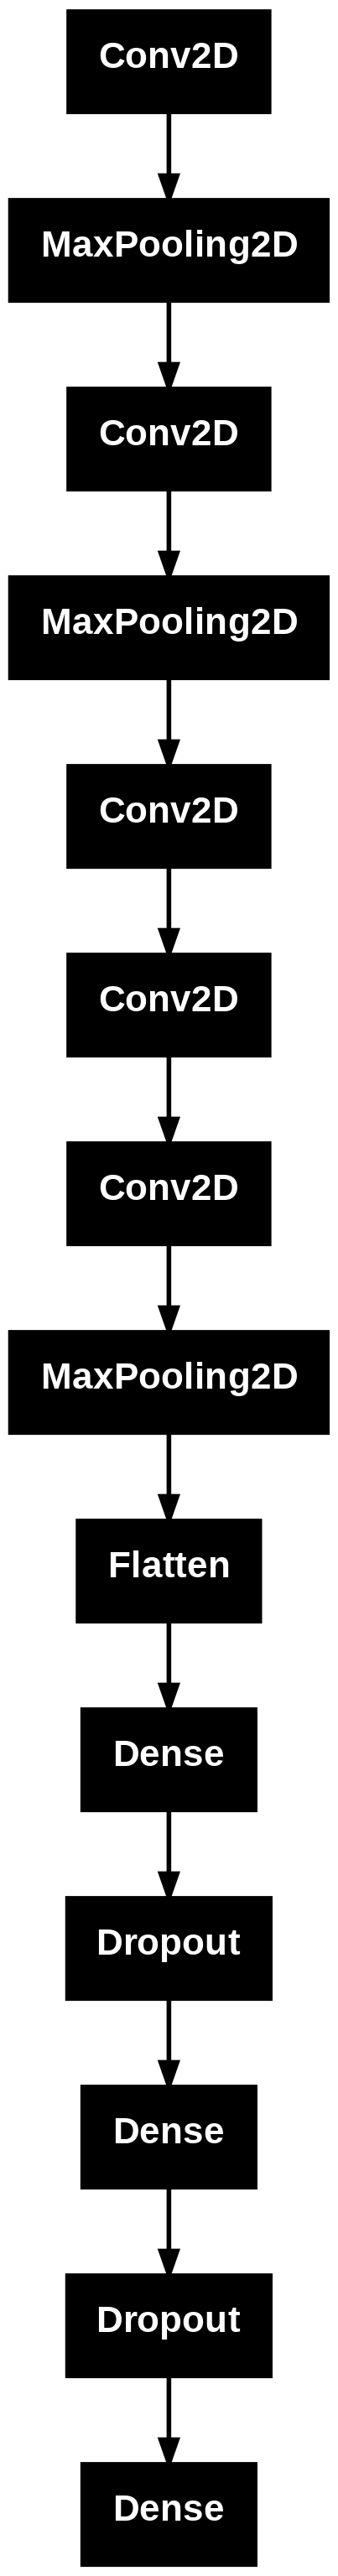

In [31]:
# prompt: plot the model

tf.keras.utils.plot_model(model)


## Train The Model

In [32]:
model.compile(
    optimizer =Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy',Recall(), Precision(),TruePositives(), FalseNegatives()]
)

In [33]:
epochs=  30

In [35]:
History = model.fit(
    x = train_batches,
    validation_data = valid_batches,
    epochs = epochs,
    verbose=2
    )


Epoch 1/30
198/198 - 152s - 770ms/step - accuracy: 0.9291 - false_negatives: 448.0000 - loss: 0.1856 - precision: 0.9291 - recall: 0.9291 - true_positives: 5868.0000 - val_accuracy: 0.9578 - val_false_negatives: 22.0000 - val_loss: 0.0927 - val_precision: 0.9578 - val_recall: 0.9578 - val_true_positives: 499.0000
Epoch 2/30
198/198 - 136s - 687ms/step - accuracy: 0.9395 - false_negatives: 382.0000 - loss: 0.1610 - precision: 0.9395 - recall: 0.9395 - true_positives: 5934.0000 - val_accuracy: 0.9616 - val_false_negatives: 20.0000 - val_loss: 0.1244 - val_precision: 0.9616 - val_recall: 0.9616 - val_true_positives: 501.0000
Epoch 3/30
198/198 - 133s - 673ms/step - accuracy: 0.9443 - false_negatives: 352.0000 - loss: 0.1487 - precision: 0.9443 - recall: 0.9443 - true_positives: 5964.0000 - val_accuracy: 0.9616 - val_false_negatives: 20.0000 - val_loss: 0.0947 - val_precision: 0.9616 - val_recall: 0.9616 - val_true_positives: 501.0000
Epoch 4/30
198/198 - 141s - 710ms/step - accuracy: 0.95

In [36]:
history_df = pd.DataFrame(History.history)

In [37]:
history_df.to_csv(os.path.join(home,'Outputs',name_output+'.csv'))

## Optionally Load Model

In [38]:
# # prompt: Load a saved model and use

# from tensorflow.keras.models import load_model
# # Load the saved model
# model = load_model(os.path.join(home,'models',this_model_name))

# # Now you can use the loaded_model for predictions or further training
# # predictions = loaded_model.predict(test_batches)


# Predict

In [39]:
test_labels= test_batches.classes

In [40]:
x_test = np.concatenate([test_batches[i][0] for i in range(len(test_batches))])

In [41]:
predictions = model.predict(  x = x_test,verbose=0)

In [42]:
dff = pd.DataFrame(predictions)

In [43]:
dff['test'] = test_labels
dff.head(10)

,0,1,test
0,0.999775,0.000225,0
1,0.998917,0.001083,0
2,0.996058,0.003942,0
3,0.998787,0.001214,0
4,0.999929,0.000071,0
5,0.999128,0.000872,0
6,0.999957,0.000043,0
7,0.999817,0.000182,0
8,0.999741,0.000259,0
9,0.998801,0.001199,0


# Taking prediction proabilities to CSV

In [44]:
dff.to_csv(os.path.join(home,'Outputs',name_output+'_prediction_probabilities.csv'))

## Confusion Matrix

In [45]:
y_pred = np.argmax(predictions,axis=-1)
y_true=test_labels

In [46]:
test_batches.class_indices
cm_plot_labels = [i for i in test_batches.class_indices.keys()]

In [47]:
# prompt: make confusion matrix from y_pred and y_test store in cm

cm = confusion_matrix(y_true,y_pred)


confusion matrix without normalization


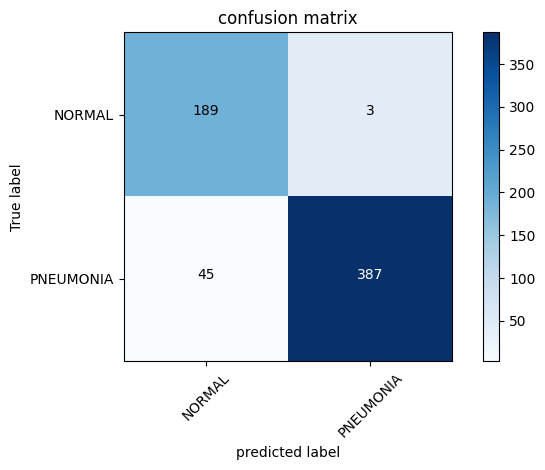

In [48]:
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title = 'confusion matrix')

## Metrics

In [49]:
# prompt: given y_pred and y_true calculate importatnt metrics to 4 dps

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for multiclass
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print metrics to 4 decimal places
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9231
Precision: 0.9401
Recall: 0.9000
F1-score: 0.9145


In [50]:
# prompt: also add sensitivity and specificity metrics then do a classficaiton report to a df

import pandas as pd
from sklearn.metrics import classification_report

# Calculate sensitivity and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print sensitivity and specificity to 4 decimal places
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# Generate classification report and convert to DataFrame
report = classification_report(y_true, y_pred, target_names=cm_plot_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Display the DataFrame
report_df


Sensitivity: 0.9923
Specificity: 0.8077


,precision,recall,f1-score,support
NORMAL,0.984375,0.807692,0.887324,234.000000
PNEUMONIA,0.895833,0.992308,0.941606,390.000000
accuracy,0.923077,0.923077,0.923077,0.923077
macro avg,0.940104,0.900000,0.914465,624.000000
weighted avg,0.929036,0.923077,0.921250,624.000000


# Save Model

In [51]:
model.save(this_model_name)

In [52]:
model_path = os.path.join(home,'models')
# home = '/content/drive/MyDrive/project/Tensorflow And Keras' #/content/drive/MyDrive/project/Project2.1/Script2_pure classification

In [53]:
# prompt: shutil.move(this_model_name,model_path) if it exists overwrite

import os
import shutil



# Check if the file exists in the destination
if os.path.exists(os.path.join(model_path, this_model_name)):
  # If it exists, remove it (overwrite)
  os.remove(os.path.join(model_path, this_model_name))

# Move the file
shutil.move(this_model_name, model_path)


'/content/drive/MyDrive/Projects/CXR/models/AlexNet.h5'

In [54]:
shutil.move(this_model_name,model_path)

Error: Destination path '/content/drive/MyDrive/Projects/CXR/models/AlexNet.h5' already exists